<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

<h1>Проект для «Викишоп» с BERT<span class="tocSkip"></span></h1> 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек

In [1]:
!pip install -q transformers catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.4 MB/s eta 0:00:00


In [2]:
# Обработка данных
import numpy as np
import pandas as pd

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers as ppb
from tqdm import notebook, tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn. metrics import f1_score
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

### Знакомство переработка данных

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=False)

In [4]:
data = data[['text','toxic']]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [7]:
data.duplicated().sum()

0

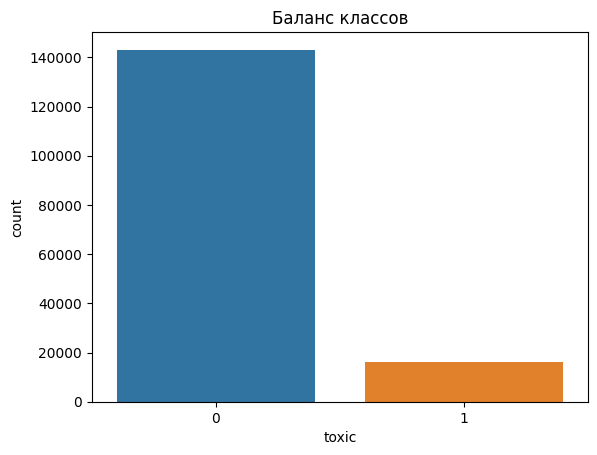

In [8]:
sns.countplot(x = 'toxic', data = data);
plt.title("Баланс классов");

* Чтобы не создавать эмбеддинги слишком долго, возьмите из выборки только 3000 случайных элементов

In [9]:
new_data = data[['text','toxic']].sample(3000).reset_index(drop=True)

In [10]:
new_data.head(10)

,text,toxic
0,"""\n\nInstead, I've removed the reference to a ...",0
1,Thanks. Happy New Year to you too. I probably ...,0
2,WAS HERE. HE POWNS NOOBS ALL DAY!,1
3,"{{unblock}Look, make a new account. The messag...",0
4,I dont see anything wrong with the link I put ...,0
5,"""\nNai soske (""""don't mention it""""). Of course...",0
6,f*ck you x2 \n\nAre you still enjoying your bl...,1
7,"""\n\nYou all are stupid. The term African Amer...",1
8,"""\nThe Graceful Slick....\nIs non other than a...",1
9,"The following link is NOT a spam link, but rat...",0


* Загрузка предобученной модели/токенизатора

In [11]:
model_class, tokenizer_class, pretrained_weights = (ppb.AutoModel, ppb.AutoTokenizer, 'unitary/toxic-bert')

In [12]:
 tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


* Преобразуем текст в номера токенов

In [13]:
tokenized = new_data['text'].apply((lambda x: tokenizer.encode(x, padding='max_length', truncation=True, 
                                                               add_special_tokens=True)))

* Найдем максимальной длины вектор во всём датасете.

In [14]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len        

512

* Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными

In [15]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

* Создадим маску

In [16]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3000, 512)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/30 [00:00<?, ?it/s]

* Сохраним полученные данные в новый датафрейм

In [19]:
lemm_toxic = np.concatenate(embeddings)

In [20]:
new_df = pd.DataFrame(lemm_toxic, index= new_data.index)

In [21]:
data_new = new_data.join(new_df, lsuffix='_left', rsuffix='_right')

In [22]:
data_new.to_csv('data_new_lemm_toxic.csv')

* Данные сохранены. Зановов считаем и сделаем разбивку для обучения наших моделей.

In [23]:
df = pd.read_csv('/content/data_new_lemm_toxic.csv', index_col = False)

In [24]:
df = df.iloc [: , 1:]

In [25]:
df.head(10)

,text,toxic,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,"""\n\nInstead, I've removed the reference to a ...",0,-0.668524,-1.012075,0.445433,-0.425507,1.099503,0.264261,-0.147757,-0.047310,...,-0.432456,-1.277784,0.111234,-0.759719,0.244113,0.811907,-0.412181,-0.773051,0.362650,0.011771
1,Thanks. Happy New Year to you too. I probably ...,0,-0.556536,-0.788890,0.518939,-0.283243,1.033466,0.194861,-0.160070,0.068645,...,-0.462660,-1.156194,0.214955,-0.720492,0.147710,1.012081,-0.488753,-0.679739,0.360003,0.081433
2,WAS HERE. HE POWNS NOOBS ALL DAY!,1,-0.110228,0.673257,0.453540,-0.500050,-0.227017,0.642047,0.915823,1.224944,...,-1.211769,0.615779,-0.563565,-0.620878,-0.465086,-0.734098,-0.190248,-0.261914,0.401774,0.035476
3,"{{unblock}Look, make a new account. The messag...",0,-0.475742,-0.773629,0.913052,-0.364221,1.056603,0.490569,0.553574,0.195458,...,-0.405248,-0.755634,0.464625,-0.486767,-0.445150,0.482836,-0.535630,-0.604065,0.754953,0.371090
4,I dont see anything wrong with the link I put ...,0,-0.409543,-0.955128,0.559810,-0.226098,0.968858,0.212163,0.035291,0.269119,...,-0.585006,-0.872573,0.158351,-0.564870,0.157533,0.966833,-0.422279,-0.850227,0.531452,0.358398
5,"""\nNai soske (""""don't mention it""""). Of course...",0,-0.402958,-0.783547,0.449764,-0.634642,1.022255,0.719170,0.372964,0.331827,...,-0.904840,-0.813216,0.046601,-0.676324,0.008394,0.388116,-0.278736,-0.689906,0.626102,0.256493
6,f*ck you x2 \n\nAre you still enjoying your bl...,1,-0.000281,0.939310,0.906840,0.524734,-0.426921,0.554818,0.417819,-0.204060,...,-1.323513,0.484673,-1.021811,0.237804,-1.083081,-1.089943,0.085394,-0.415312,-0.205645,-0.353331
7,"""\n\nYou all are stupid. The term African Amer...",1,-0.282408,0.188373,-0.170497,-0.875169,0.293922,1.114821,0.946724,1.075430,...,-1.136657,0.633450,-0.646802,-1.238392,0.206694,-0.294773,-0.286139,-0.393394,-0.196115,0.404435
8,"""\nThe Graceful Slick....\nIs non other than a...",1,-0.533842,0.390976,0.921185,0.290132,-0.486912,0.676412,0.767043,0.514356,...,-0.981447,0.501149,-0.892705,-0.388172,-0.837197,-0.978212,0.287582,-0.244589,0.316982,0.188626
9,"The following link is NOT a spam link, but rat...",0,-0.689445,-0.966722,0.598824,-0.392439,0.969672,0.169701,-0.080501,0.047043,...,-0.408899,-1.250794,0.097098,-0.742753,0.162316,0.928127,-0.457461,-0.784491,0.368440,0.095940


In [26]:
features = df.drop(['toxic', 'text'], axis = 1)
target = df['toxic']
target.shape, features.shape

((3000,), (3000, 768))

In [27]:
target.value_counts()

0    2670
1     330
Name: toxic, dtype: int64

In [28]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                              test_size=0.4, random_state=12345)

## Обучение

### Обучим модель CatBoost

In [30]:
cat_model = CatBoostClassifier(verbose=False, task_type="GPU", auto_class_weights='Balanced',
                              early_stopping_rounds=20)

parameters_cat = {'iterations':[100, 300, 400],
                  'learning_rate':[0.2, 0.3, 0.5, 0.7],
                  'l2_leaf_reg':[3, 6, 8]
                 }

model_cat = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_cat, 
                               scoring='f1', n_iter=5, cv = 3)

In [31]:
%%time

model_cat.fit(features_train, target_train)
print("Параметры:", model_cat.best_params_)
print("F1 score: " + str(round(100*model_cat.best_score_, 2)) + "%")

Параметры: {'learning_rate': 0.5, 'l2_leaf_reg': 8, 'iterations': 300}
F1 score: 95.68%
CPU times: user 59.5 s, sys: 30.1 s, total: 1min 29s
Wall time: 56.4 s


### Обучим модель LightGBM

In [32]:
light_model = LGBMClassifier(class_weight = 'balanced')


param_light = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': [0.01,0.1,0.5],
    'subsample_for_bin': [20000,50000,100000,120000,150000],
    'min_child_samples': [20,50,100,200,500],
    'colsample_bytree': [0.6,0.8,1],
    "max_depth": [5,10,50,100]
}

model_light = RandomizedSearchCV(estimator=light_model, param_distributions=param_light, 
                               scoring='f1', n_iter=5, cv = 3)

In [33]:
%%time

model_light.fit(features_train, target_train)
print("Параметры:", model_light.best_params_)
print("F1 score: " + str(round(100*model_light.best_score_, 2)) + "%")

Параметры: {'subsample_for_bin': 120000, 'num_leaves': 56, 'min_child_samples': 500, 'max_depth': 5, 'learning_rate': 0.5, 'colsample_bytree': 0.6, 'boosting_type': 'gbdt'}
F1 score: 95.91%
CPU times: user 39.9 s, sys: 1.31 s, total: 41.2 s
Wall time: 46.6 s


### Модель LogisticRegression

In [34]:
lr_model = LogisticRegression(random_state=12345, solver='liblinear')

param_lr= {'C': [0.01, 0.1, 0.5, 1, 5]}

model_lr = RandomizedSearchCV(estimator=lr_model, param_distributions=param_lr, 
                               scoring='f1', n_iter=10, cv = 3)

In [35]:
%%time

model_lr.fit(features_train, target_train)
print("Параметры:", model_lr.best_params_)
print("F1 score: " + str(round(100*model_lr.best_score_, 2)) + "%")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Параметры: {'C': 0.1}
F1 score: 94.57%
CPU times: user 3.2 s, sys: 1.63 s, total: 4.83 s
Wall time: 2.92 s


Обучили три модели получили хороший результат. **CatBoost:** F1 score: 95.68%, **LightGBM** F1 score: 95.91% и модель **LogisticRegression** F1 score: 94.57%. Для тестовой выборки возьмем **LightGBM**

## Тестирование

Сравненим с dummy моделью

In [37]:
dummy = DummyClassifier(strategy='most_frequent', random_state=12345).fit(features_train, target_train)
predicted_test = dummy.predict(features_test)
F1 = f1_score(target_test, predicted_test)
print("F1 score:", F1*100)

F1 score: 0.0


In [40]:
%%time

predict_light = model_light.best_estimator_.predict(features_test)
F1_score = f1_score(target_test, predict_light)
print("F1 score: " + str(round(100*F1_score, 2)) + "%")

F1 score: 94.24%
CPU times: user 24.3 ms, sys: 0 ns, total: 24.3 ms
Wall time: 47.5 ms


**Вывод** Задачей нашего проекта было сделать инструмент для магазина «Викишоп», который будет искать токсичные комментарии и отправлять их на модерацию. Для задачи с текстом будем использовали модель BERT, выборка из 3000 случайных элементов. После кодировки обучили три модели CatBoost, LightGBM и LogisticRegression все три показали хороший результат на тестовых данных CatBoost: F1 score: 95.68%, LightGBM F1 score: 95.91% и модель LogisticRegression F1 score: 94.57%. Для тестовой выборки использовали LightGBM получили F1 score: 94.24%.